In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[]

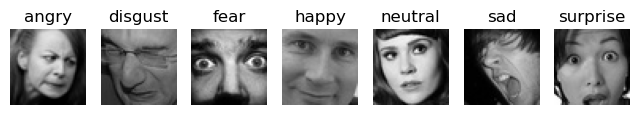

In [3]:
i = 1
plt.figure(figsize=(8, 8))
try:
    for expression in os.listdir('images/validation/'):
        img = load_img(
            f"images/validation/{expression}/{os.listdir(f'images/validation/{expression}')[0]}"
        )
        plt.subplot(1, 7, i)
        plt.imshow(img)
        plt.title(expression)
        plt.axis('off')
        i += 1
except:
    for expression in os.listdir('/kaggle/input/face-expression-recognition-dataset/images/validation/'):
        img = load_img(
            f"/kaggle/input/face-expression-recognition-dataset/images/validation/{expression}/{os.listdir(f'/kaggle/input/face-expression-recognition-dataset/images/validation/{expression}')[0]}"
        )
        plt.subplot(1, 7, i)
        plt.imshow(img)
        plt.title(expression)
        plt.axis('off')
        i += 1

plt.show()

# Check the amount of data in each folder in training dataset

In [4]:
try:
    for expression in os.listdir('images/train/'):
        print(expression, "folder contains\t\t", len(os.listdir('images/train/' + expression)), "images")
except:
    for expression in os.listdir('/kaggle/input/face-expression-recognition-dataset/images/train/'):
        print(expression, "folder contains\t\t",
              len(os.listdir('/kaggle/input/face-expression-recognition-dataset/images/train/' + expression)), "images")

angry folder contains		 3993 images
disgust folder contains		 436 images
fear folder contains		 4103 images
happy folder contains		 7164 images
neutral folder contains		 4982 images
sad folder contains		 4938 images
surprise folder contains		 3205 images


# Check the amount of data in each folder in testing dataset

In [5]:
try:
    for expression in os.listdir('images/validation/'):
        print(expression, "folder contains\t\t", len(os.listdir('images/validation/' + expression)), "images")
except:
    for expression in os.listdir('/kaggle/input/face-expression-recognition-dataset/images/validation/'):
        print(expression, "folder contains\t\t",
              len(os.listdir('/kaggle/input/face-expression-recognition-dataset/images/validation/' + expression)),
              "images")

angry folder contains		 960 images
disgust folder contains		 111 images
fear folder contains		 1018 images
happy folder contains		 1825 images
neutral folder contains		 1216 images
sad folder contains		 1139 images
surprise folder contains		 797 images


In [6]:
model = tf.keras.models.Sequential(
    [
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1()),
        Dropout(0.5),
        Dense(7, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1())
    ]
)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 256)         0

# Data Augmentation

In [7]:
try:
    datagen_train = ImageDataGenerator(
        rescale=1. / 255,
        zoom_range=0.3,
        horizontal_flip=True
    )

    train_generator = datagen_train.flow_from_directory(
        '/kaggle/input/face-expression-recognition-dataset/images/train/',
        batch_size=64,
        target_size=(48, 48),
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical'
    )

    datagen_test = ImageDataGenerator(
        rescale=1. / 255,
        zoom_range=0.3,
        horizontal_flip=True
    )

    test_generator = datagen_test.flow_from_directory(
        '/kaggle/input/face-expression-recognition-dataset/images/validation/',
        batch_size=64,
        target_size=(48, 48),
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical'
    )
except:
    datagen_train = ImageDataGenerator(
        rescale=1. / 255,
        zoom_range=0.3,
        horizontal_flip=True
    )

    train_generator = datagen_train.flow_from_directory(
        'images/train/',
        batch_size=64,
        target_size=(48, 48),
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical'
    )

    datagen_test = ImageDataGenerator(
        rescale=1. / 255,
        zoom_range=0.3,
        horizontal_flip=True
    )

    test_generator = datagen_test.flow_from_directory(
        'images/validation/',
        batch_size=64,
        target_size=(48, 48),
        shuffle=True,
        color_mode='grayscale',
        class_mode='categorical'
    )

steps_per_epoch = train_generator.n / train_generator.batch_size
testing_steps = test_generator.n / test_generator.batch_size

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
train_generator = np.array(train_generator)
train_generator

In [ ]:
history = model.fit(
    x=train_generator,
    epochs=100,
    validation_split=0.2,
    batch_size=10
)

In [ ]:
model.evaluate(
    x=test_generator,
    steps=testing_steps
)

# Plot the training and validation accuracy and loss at each epoch

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()